<a href="https://colab.research.google.com/github/avkornaev/Python-for-image-processing-course/blob/main/Cells_counter_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary.

The cells counter algorithm is based on watershed method. If you want to know more, please check the following links: https://imagej.net/plugins/classic-watershed,
https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

**Install libraries**.

Execute code bellow just once to install the libraries. Then you may comment 'pip' lines using # at the begining of lines of the code.

In [1]:
!pip install -Uqq fastbook
!pip install czifile
!pip install tifffile
!pip install imagecodecs

**Connect to Google disk.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import libraries.**

In [3]:
import fastbook
from fastbook import *
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from google.colab.patches import cv2_imshow
from scipy import ndimage
from skimage import measure, color, io, img_as_ubyte, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.segmentation import clear_border, join_segmentations
import pandas as pd
import czifile
import imagecodecs
#import tifffile

**Check the settings.**

In [4]:
#Image under study
img_path = '/content/drive/MyDrive/Cells_count/'
img_title = 'B16_1122_2_2.czi' # 'B16_control 2_2.czi'
pixels2microns = 0.396 #scale factor (check the image properties in Zen or Apeer)

#Visualisation
img_size = [] # empty [] or rectangle coordinates, e.g. [0,0,1024,1024]
fig_size = (30,30) # figures size
img_map  = 'Blues' # image map. For example, 'gray','hot','jet','Blues' et al. If you want to know more, please type the following code: help(plt.imshow)
img_map1 = 'jet'

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255,255,255)
lineType  = 2

#Filtering
kernel = np.ones((5,5),np.uint8)
kernel4filt = 5
ps = 5 # patch_size
patchDist = 3 # patch_distance
hc = 115 # coefficient

numberOfIter = 2 #number of iterations
dist_transf_ratio = 0.1 # distance transform ratio
dist_transf_param = 5
markers_bias = 100

clearBorder = 'off' # delete markers at the borders: 'on' or 'off'

**Download "czi" image and create slices of the image.**

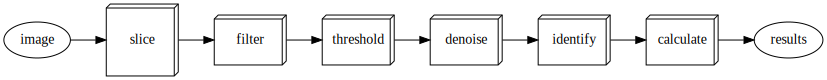

In [5]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=1] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [6]:
img = czifile.imread(img_path + img_title)

if img_size == []:
  img_size = [0,0,img.shape[5],img.shape[6]] # full size

img_slice = img[0,0,0,:,0,img_size[0]:img_size[2],img_size[1]:img_size[3],0]# image in a form of 3D matrix
img0 = img_slice[0,:,:] # 0 channel which is fluo4-T1 (highlights the apoptosed cells)
img1 = img_slice[1,:,:] # 1 channel which is H3342-T2 (highlights all the cells)
channels = [img0,img1] # channels of the image

nc = len(channels)
n = [i for i in range(nc)] # auxiliary variable 

print('CZI image shape: ',img.shape)# ?, ?, ?,number of chanels,x size,y size, ?
for i in n:
  print(i,'channel shape: ',channels[i].shape, channels[i].dtype, type(channels[i]))
  print(np.amax(channels[i]))
print('0 channel shape: ',img0.shape,img0.dtype,type(img0))
print(np.amax(img0))
print('1 channel shape: ',img1.shape,img1.dtype,type(img1))
print(np.amax(img1))

CZI image shape:  (1, 1, 1, 2, 1, 3277, 3277, 1)
0 channel shape:  (3277, 3277) uint16 <class 'numpy.ndarray'>
65535
1 channel shape:  (3277, 3277) uint16 <class 'numpy.ndarray'>
65535
0 channel shape:  (3277, 3277) uint16 <class 'numpy.ndarray'>
65535
1 channel shape:  (3277, 3277) uint16 <class 'numpy.ndarray'>
65535


**Create templates (empty lists).**

In [7]:
channelsF = [0]*nc # filtered channels template
img_path_temp = [0]*nc # another one template
channelsFGray = [0]*nc # and another one
ret = [0]*nc # one more template
thresh = [0]*nc # one more template
opening = [0]*nc # one more template
sure_bg = [0]*nc # one more template
sure_fg = [0]*nc # one more template
ret1 = [0]*nc # one more template
dist_transform = [0]*nc # one more template
unknown = [0]*nc # one more template
ret2 = [0]*nc # one more template
markers = [0]*nc # one more template
markersi= [0]*nc # one more template
channelsFB = [0]*nc # one more template
channelsFW = [0]*nc # one more template
channelsFWi= [0]*nc # one more template
regions = [0]*nc
numberOfCells = [0]*nc

**Filter channel images.**

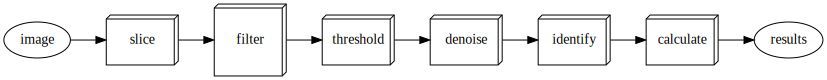

In [8]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=1] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')
# https://laptrinhx.com/five-lessons-from-my-data-science-internship-at-hara-1112784335/

The non-local means denoising and the median filter are performed. 

In [9]:
for i in n:
  # "denoise_nl_means" performs non-local means denoising
  sigma_est = np.mean(estimate_sigma(channels[i], multichannel=False))
  patch_kw = dict(patch_size=ps, patch_distance=patchDist, multichannel=False)
  channelsF[i] = denoise_nl_means(channels[i], h=hc*sigma_est, fast_mode=False, **patch_kw)
  
  channelsF[i] = np.uint16(channelsF[i])

  # Apply a multidimensional median filter
  channelsF[i] = ndimage.median_filter(channelsF[i], size=kernel4filt)

  print(i,'channel sigma estimation = ',sigma_est)
  print(i,'channel shape: ',channelsF[i].shape, channelsF[i].dtype, type(channelsF[i]))
  print(np.amax(channelsF[i]))
   

0 channel sigma estimation =  2.773226281568312
0 channel shape:  (3277, 3277) uint16 <class 'numpy.ndarray'>
65535
1 channel sigma estimation =  223.6421822668764
1 channel shape:  (3277, 3277) uint16 <class 'numpy.ndarray'>
65535


**Visualize channels before and after filtering.**

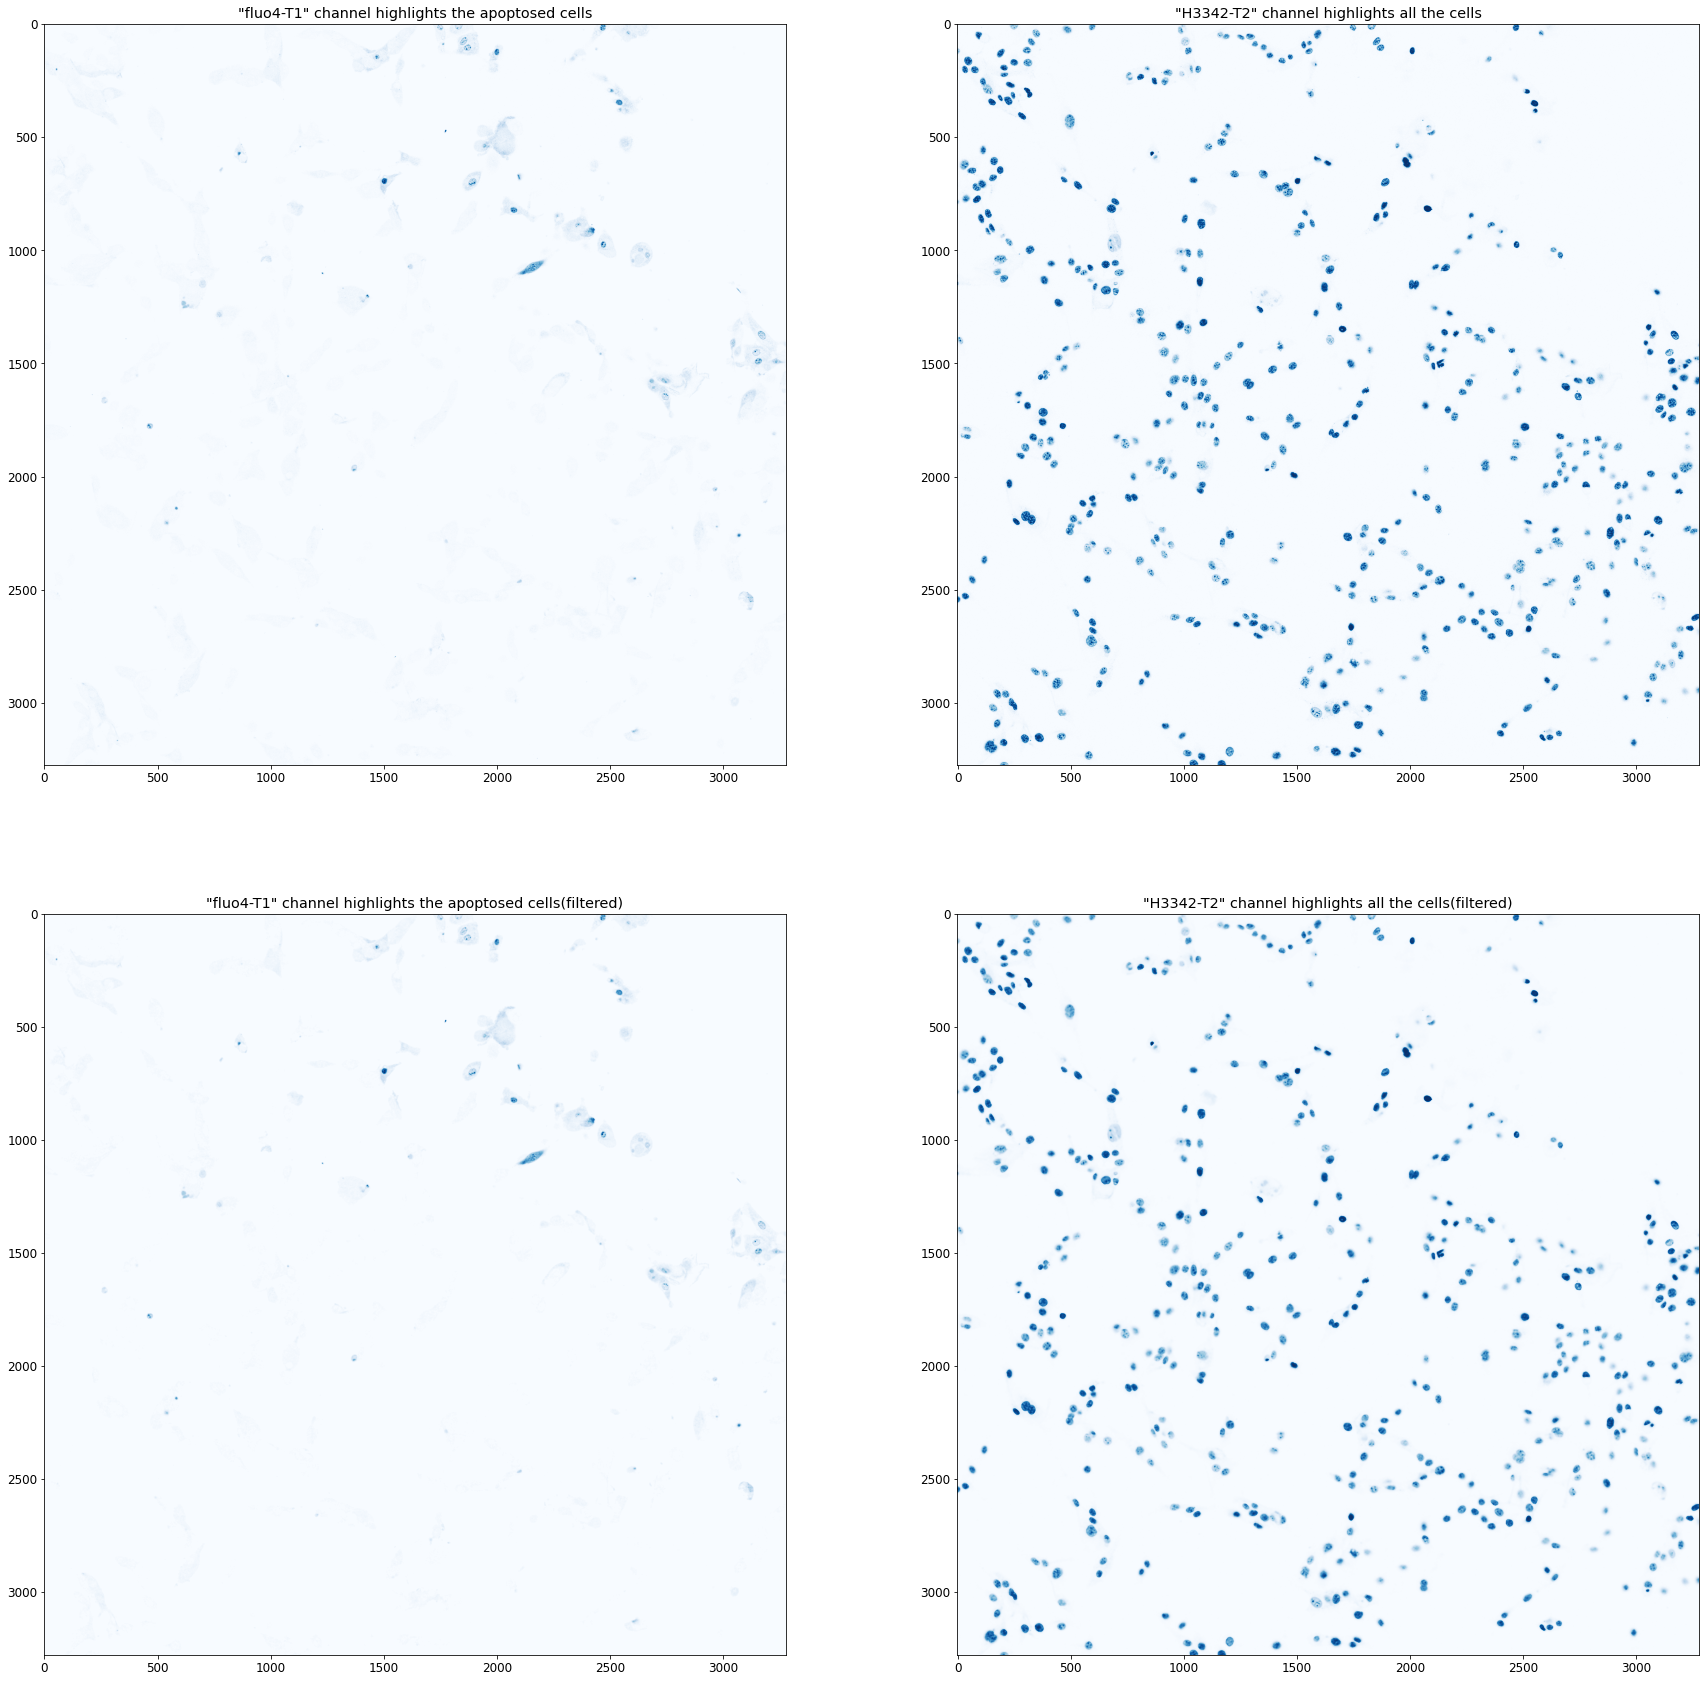

In [10]:
titles = ['"fluo4-T1" channel highlights the apoptosed cells',
          '"H3342-T2" channel highlights all the cells']
plt.figure(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channels[i],cmap=img_map)
  plt.title(titles[i])
  plt.subplot(2,2,i+3)
  plt.imshow(channelsF[i],cmap=img_map)
  plt.title(titles[i]+'(filtered)')  

In [11]:
#plt.figure(figsize=fig_size)
#plt.imshow(channelsF[1],cmap = img_map)

**Create tepmorary 'tiff' files.**

In [12]:
for i in n:
  img_path_temp[i] = img_path + img_title[0:-4] + '_ch' + str(i) + '.tiff' # path 0
  cv2.imwrite(img_path_temp[i], channelsF[i]) # save channels in a temporary tiff file
print(img_path_temp)

['/content/drive/MyDrive/Cells_count/B16_1122_2_2_ch0.tiff', '/content/drive/MyDrive/Cells_count/B16_1122_2_2_ch1.tiff']


**Read images using OpenCV.**

In [13]:
for i in n:
  channelsFGray[i] = cv2.imread(img_path_temp[i],cv2.IMREAD_GRAYSCALE)
  print(type(channelsFGray[i]),channelsFGray[i].shape,channelsFGray[i].dtype)

<class 'numpy.ndarray'> (3277, 3277) uint8
<class 'numpy.ndarray'> (3277, 3277) uint8


**Threshold and delete noise.**

Threshold image to binary using 'OTSU'. All the thresholded pixels are set to 255. Then remove noise using 'opening' and remove edge touching with 'clear_border' function (optional).

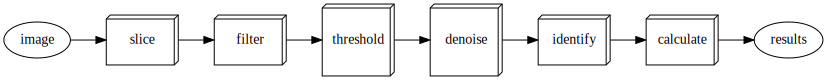

In [14]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=1] denoise[shape=box3d width=1 height=1] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [15]:
for i in n:
  ret[i], thresh[i] = cv2.threshold(channelsFGray[i], 0, 255, 
                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  opening[i] = cv2.morphologyEx(thresh[i],cv2.MORPH_OPEN,kernel,
                                iterations = numberOfIter)
  if clearBorder == 'on':
    opening[i] = clear_border(opening[i])

**Identify background and foreground area using OpenCV distance transformation. Apply watershed.**

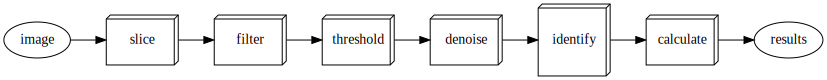

In [16]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=1] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

Find sure background and sure foreground regions.

In [17]:
for i in n:
  sure_bg[i] = cv2.dilate(opening[i],
                          kernel,iterations=numberOfIter) # sure background
  dist_transform[i] = cv2.distanceTransform(opening[i],cv2.DIST_L2,
                                            dist_transf_param)
  
  ret1[i], sure_fg[i] = cv2.threshold(dist_transform[i],
                                      dist_transf_ratio*dist_transform[i].max(),
                                      255,0)
  sure_fg[i] = np.uint8(sure_fg[i]) # sure foreground

To find the apoptosed cells the channels intersection condition should be met. The intersectioin is represented by 'and' logical operation.

In [18]:
sure_fg[0] = cv2.bitwise_and(sure_fg[0], sure_fg[1])

Add markers and apply watershed.

In [19]:
for i in n:
  unknown[i] = cv2.subtract(sure_bg[i], sure_fg[i])
  ret2[i], markers[i] = cv2.connectedComponents(sure_fg[i])
  markers[i] = markers[i] + markers_bias
  markers[i][unknown[i]==255] = 0

  markers[i] = cv2.watershed(cv2.imread(img_path_temp[i]),markers[i]) #The boundary regions will be marked as -1
  channelsFB[i] = cv2.imread(img_path_temp[i])
  channelsFB[i][markers[i] == -1] = [255,0,0] # highlight borders with red 
  channelsFW[i] = color.label2rgb(markers[i], bg_label = 0)

Visualize.

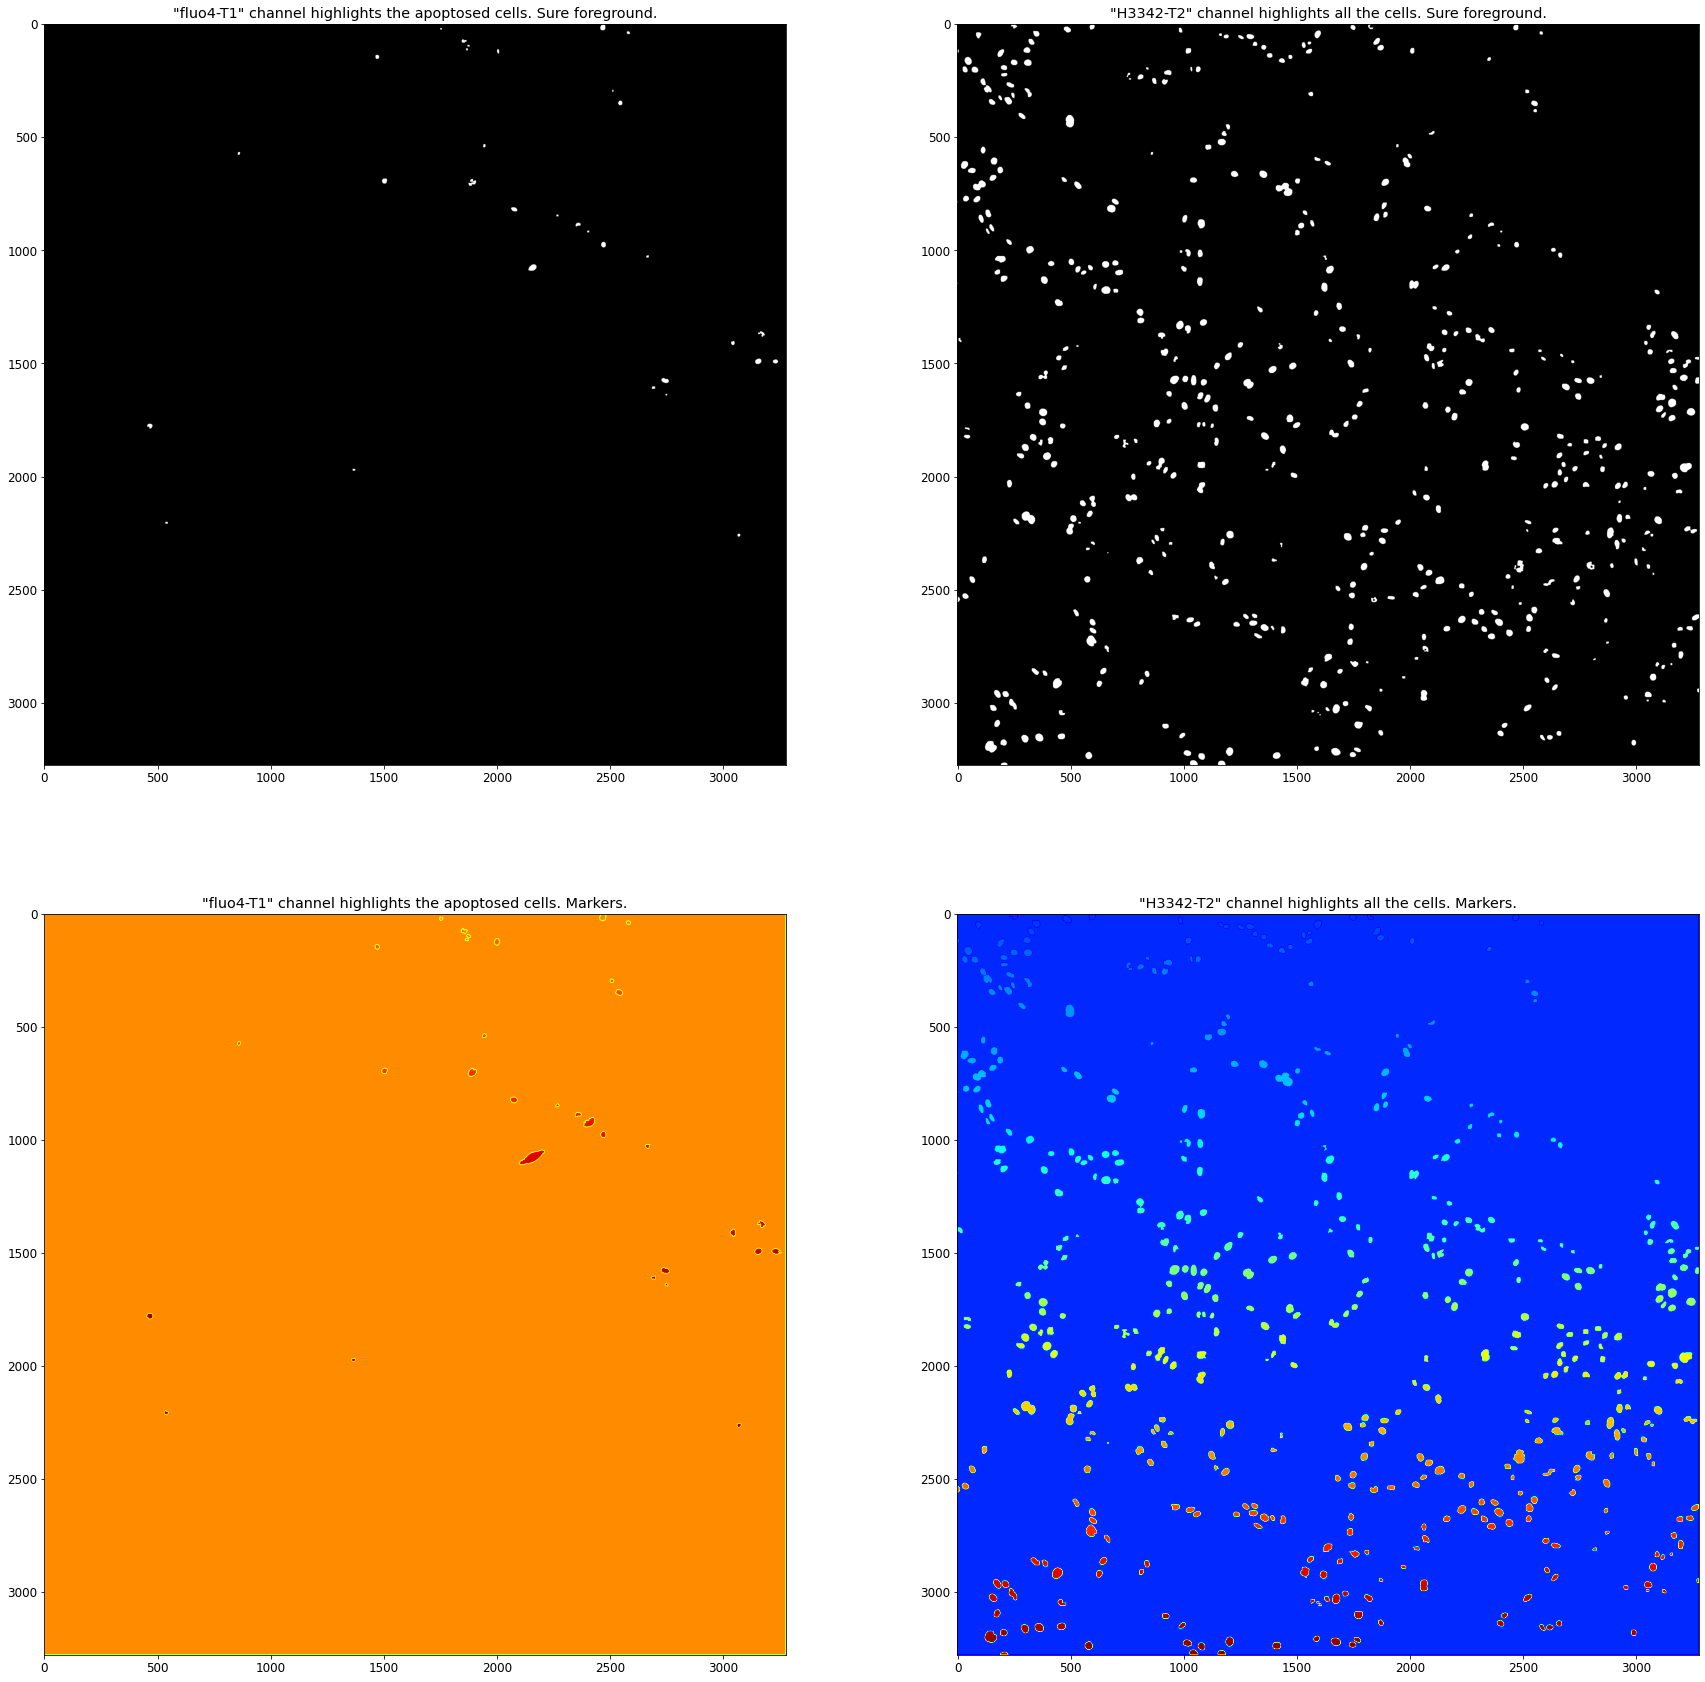

In [20]:
plt.figure(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(sure_fg[i],cmap='binary_r')
  plt.title(titles[i]+'. Sure foreground.')
  plt.subplot(2,2,i+3)
  plt.imshow(markers[i],cmap=img_map1)
  plt.title(titles[i]+ '. Markers.')

Compare channels intersections to find the apoptosed cells.

In [21]:
#channelsFWIntersection = cv2.bitwise_and(sure_fg[0], sure_fg[1])
#channelsFWIntersection = join_segmentations(sure_fg[0], sure_fg[1]) # intersection
#channelsFWIGray = cv2.cvtColor(channelsFWIntersection, cv2.COLOR_BGR2GRAY) # convert to gray image

In [22]:
#retI,threshI = cv2.threshold(channelsFWIntersection, 0, 255, 
#                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)

**Calculate metrics.**

https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

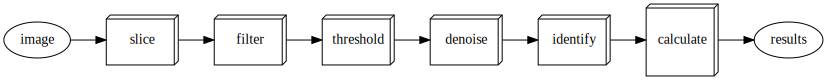

In [23]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=1]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [24]:
# Calculate metrics for channels
for i in n:
  regions[i] = measure.regionprops(markers[i], intensity_image=channels[i])
  numberOfCells[i] = len(regions[i])-1
  #print(regions[i])
print('Numbers of cells in channel images are equal to',numberOfCells)
print('Note: the number of cells in channel 0 was calculated according to the intersecting condition.')

# # Calculate metrics for intersection
# regionsI = measure.regionprops(channelsFWIntersection, intensity_image=channels[0])
# numberOfApoptosedCells = len(regionsI)-1
# print('Numbers of appoptosed cells is equal to',numberOfApoptosedCells)


Numbers of cells in channel images are equal to [32, 503]
Note: the number of cells in channel 0 was calculated according to the intersecting condition.


In [25]:
#Append intersection
#regions.append(regionsI)

**Visualise and save metrics data.**

In [26]:
d = [0]*(nc)
df_temp = [0]*(nc)

for i in [i for i in range(nc)]:
  nr = [i for i in range(len(regions[i]))]
  d[i] = pd.DataFrame()
  for j in nr:
    df_temp[i] = pd.DataFrame({'No':j, 
                          'Area (mum^2)':int(regions[i][j].area*(pixels2microns**2)),
                          'Equiv.diam. (mum)': regions[i][j].equivalent_diameter*pixels2microns,
                          'Major axis length (mum)':regions[i][j].major_axis_length*pixels2microns,
                          'Minor axis length (mum)':regions[i][j].minor_axis_length*pixels2microns,
                          'Mean intensity':regions[i][j].mean_intensity,
                          'Euler number': regions[i][j].euler_number,
                          'Centroid':[regions[i][j].centroid],
                          'Bounding box':[regions[i][j].bbox]})
    d[i] = pd.concat([d[i],df_temp[i]])
    d[i].to_csv(img_path + img_title[0:-4] +'_channel_'+str(i) + '.csv')  

In [27]:
# Channel 0 ("fluo4-T1") intersected with Channel 1.
d[0]

,No,Area (mum^2),Equiv.diam. (mum),Major axis length (mum),Minor axis length (mum),Mean intensity,Euler number,Centroid,Bounding box
0,0,1679261,1462.225259,1498.206936,1497.195891,274.389123,-30,"(1639.0942359171968, 1637.0049373926436)","(1, 1, 3276, 3276)"
0,1,95,11.008917,12.221461,10.007912,34153.963756,1,"(18.210873146622735, 2467.7611202635912)","(4, 2455, 34, 2482)"
0,2,20,5.133779,5.758672,5.485683,25141.333333,1,"(24.5, 1753.628787878788)","(18, 1746, 32, 1761)"
0,3,31,6.303428,7.121601,5.700066,19842.331658,1,"(42.06532663316583, 2580.547738693467)","(35, 2572, 50, 2590)"
0,4,53,8.227163,10.795665,7.190046,22667.581121,1,"(79.5693215339233, 1854.3421828908554)","(68, 1842, 91, 1869)"
0,5,22,5.305909,7.058673,4.158430,24420.198582,1,"(101.25531914893617, 1875.1205673758866)","(96, 1867, 109, 1884)"
0,6,17,4.686478,6.595931,4.280907,31399.145455,1,"(115.82727272727273, 1867.909090909091)","(107, 1860, 122, 1876)"
0,7,71,9.541852,11.145868,8.211203,41254.127193,1,"(127.17763157894737, 1999.905701754386)","(114, 1990, 142, 2011)"
0,8,44,7.543496,7.975494,7.185227,28764.624561,1,"(148.79298245614035, 1471.122807017544)","(140, 1462, 159, 1481)"
0,9,27,5.944795,6.326367,5.739938,29856.480226,1,"(298.6666666666667, 2507.6497175141244)","(291, 2500, 307, 2516)"


In [28]:
# Channel 1 ("H3342-T2").
d[1]

,No,Area (mum^2),Equiv.diam. (mum),Major axis length (mum),Minor axis length (mum),Mean intensity,Euler number,Centroid,Bounding box
0,0,1621590,1436.897267,1504.339485,1491.856800,614.861320,-482,"(1633.6653412275582, 1643.3315265933024)","(1, 1, 3276, 3276)"
0,1,102,11.427181,14.271211,10.116396,23791.091743,1,"(12.013761467889909, 250.8256880733945)","(1, 234, 28, 268)"
0,2,68,9.319549,13.476325,8.047582,33423.250575,1,"(16.02528735632184, 1824.4528735632184)","(1, 1814, 30, 1839)"
0,3,89,10.696152,11.698563,9.869182,35363.460733,1,"(16.2652705061082, 596.1431064572425)","(3, 583, 31, 610)"
0,4,98,11.179887,12.351331,10.144303,50823.840256,1,"(18.723642172523963, 2467.9169329073484)","(4, 2455, 34, 2482)"
...,...,...,...,...,...,...,...,...,...
0,499,90,10.761288,12.430360,9.343403,48319.517241,1,"(3230.803448275862, 1746.353448275862)","(3219, 1732, 3243, 1762)"
0,500,124,12.606856,13.646142,11.686306,48527.447236,1,"(3238.3354271356784, 1079.8090452261306)","(3223, 1064, 3255, 1095)"
0,501,106,11.634965,15.354194,9.182905,48937.758112,1,"(3265.839233038348, 1044.570796460177)","(3254, 1027, 3276, 1065)"
0,502,88,10.630617,14.307498,8.248459,54454.651943,1,"(3266.9575971731447, 1168.3763250883392)","(3256, 1152, 3276, 1188)"


In [29]:
# Channels intersection, that is a data frame of appoptosed cells
#d[2]

**Visualize boundaries and cells.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


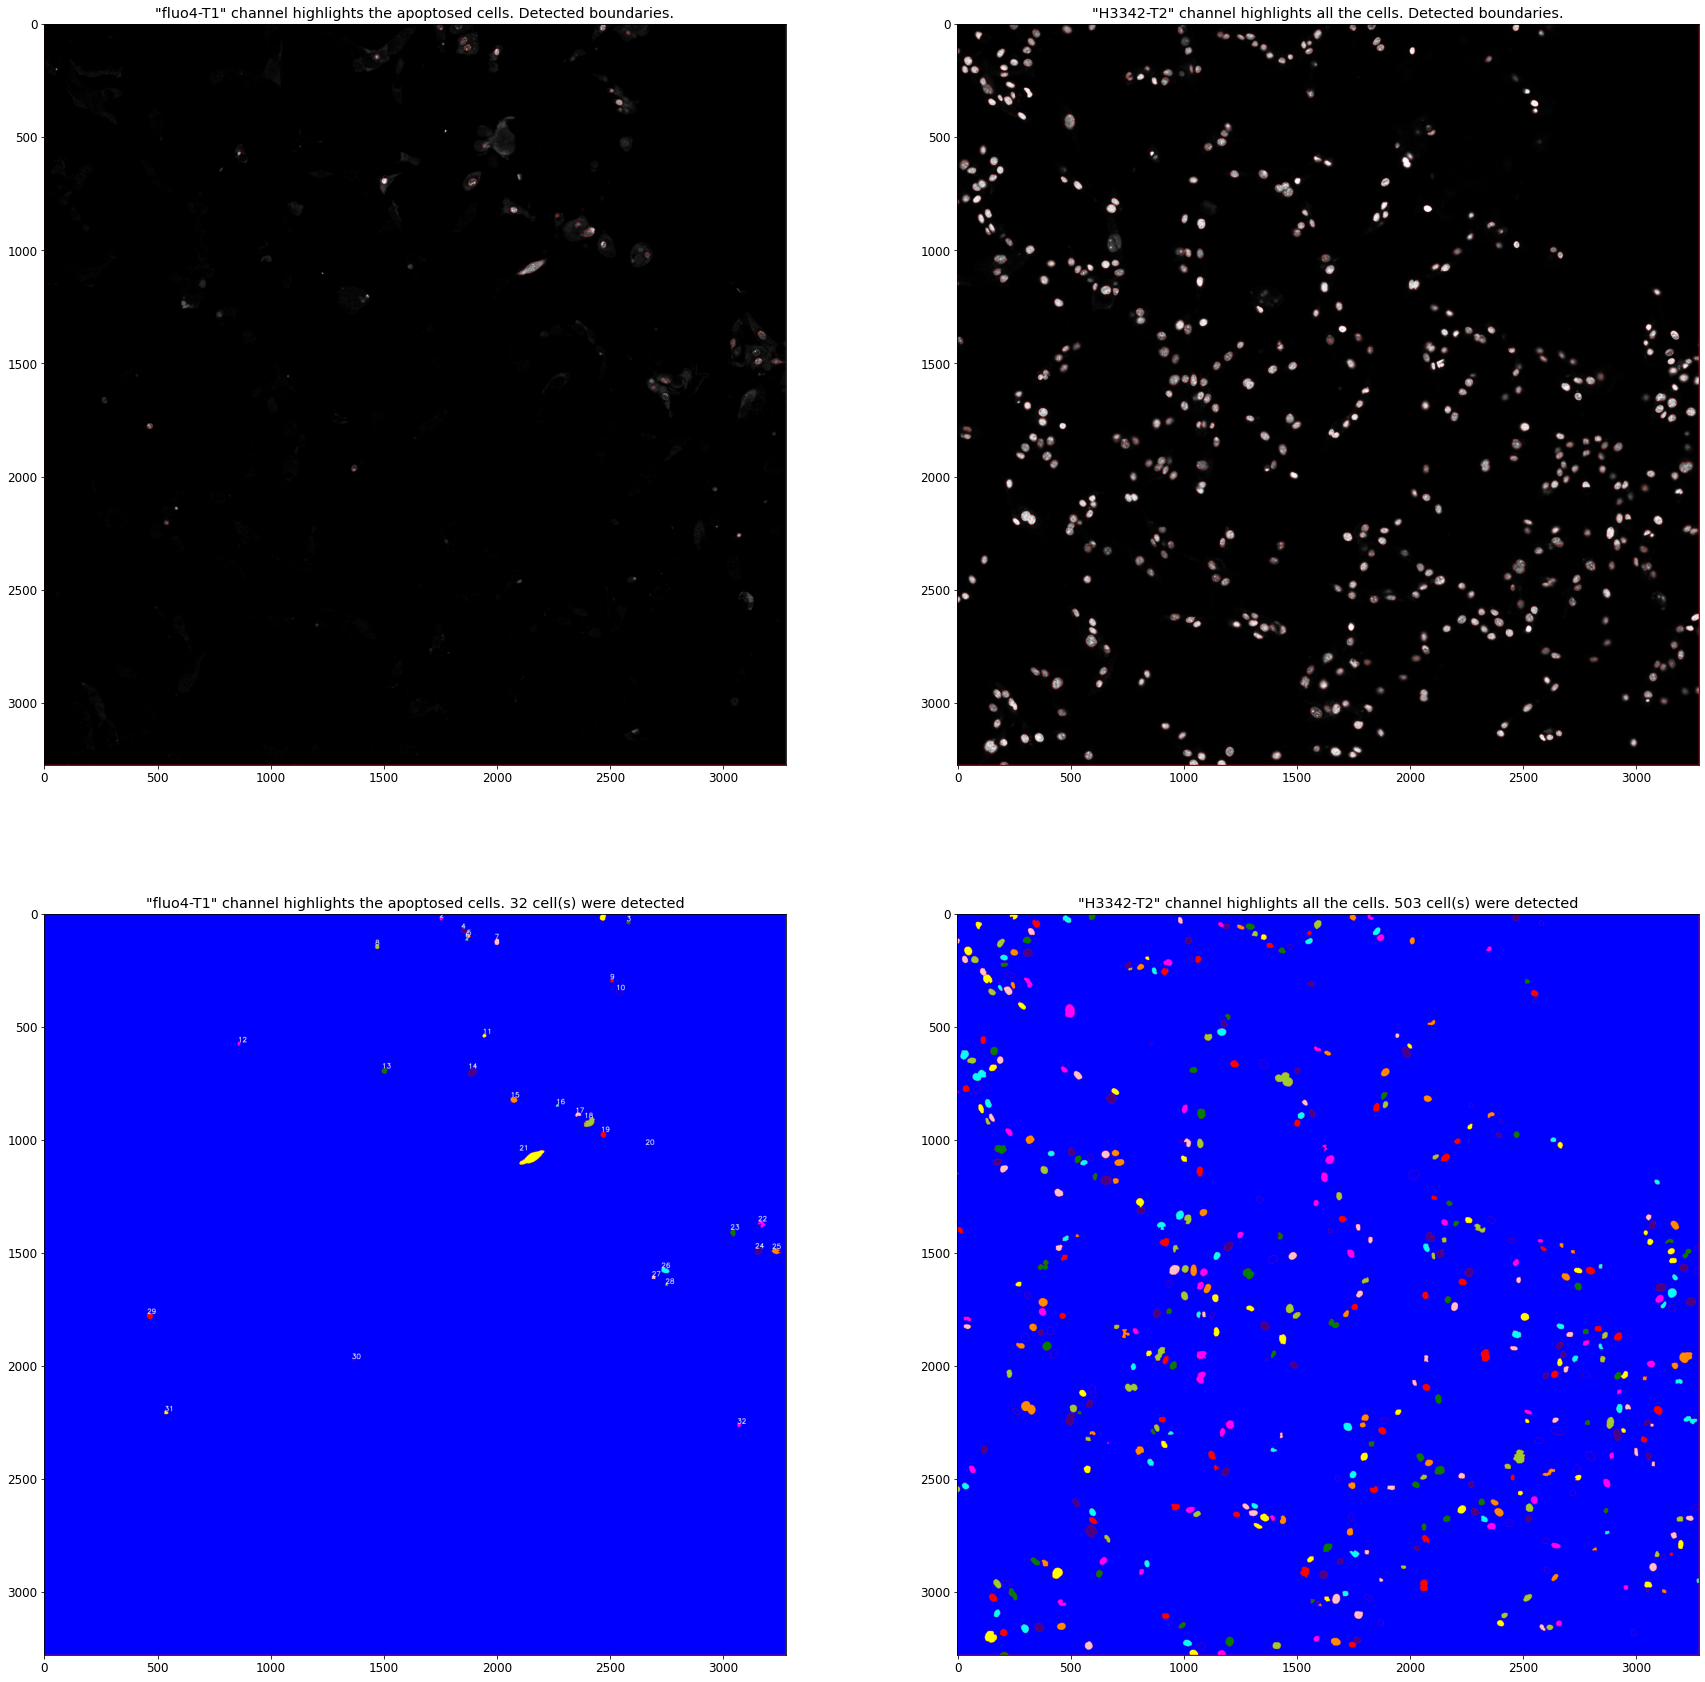

In [30]:
# Enumerate apoptosed cells on image
for j in [i for i in range(len(regions[0]))]:
  cellPosition = (regions[0][j].bbox[1],regions[0][j].bbox[0])
  cv2.putText(channelsFW[0],str(j),
              cellPosition,font,fontScale,fontColor,lineType)
# Visualize
fig, ax = plt.subplots(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channelsFB[i],cmap=img_map)
  plt.title(titles[i]+'. Detected boundaries.')
  plt.subplot(2,2,i+3)
  plt.imshow(channelsFW[i],cmap=img_map1)
  plt.title(titles[i]+ '. ' + str(numberOfCells[i]) + ' cell(s) were detected')

**Compare the resulsts.** 

Data obtained from the folder 

In [ ]:
IDs = ['']

Read csv file with data obtained from labeling on Appeer platform https://www.apeer.com/.

In [32]:
dl = pd.read_csv(img_path + img_title + '_annotation.csv')

In [33]:
print('The number of alive cells is ', len(dl[(dl.Class=='alive')]))
print('The number of apoptosed cells is ', len(dl[(dl.Class=='apoptosed')]))

The number of alive cells is  466
The number of apoptosed cells is  40


In [ ]:
dl[(dl.Class=='alive')].head()

In [ ]:
dl[(dl.Class=='apoptosed')].head()

In [34]:
(40-32)/40

0.2

**Some links.**

Image Filtering https://cs.nyu.edu/~fergus/teaching/vision/3_filtering.pdf

Cells count https://www.biorxiv.org/content/10.1101/181495v2.full